In [1]:
import pandas as pd
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training import train_state
from functools import partial
# from relative_fitness_mechanisms.selective_pressure_prediction import (create_lagged_features, 
#                                                                        process_inputs_all, 
#                                                                        withhold_test_locations_and_split, 
#                                                                        create_training_batches,
#                                                                       train_step, 
#                                                                       loss_fn)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Prepping data

import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from selective_pressure_prediction import (create_lagged_features, 
                                           process_inputs_all, 
                                            withhold_test_locations_and_split, 
                                            create_training_batches,
                                            train_step, 
                                            loss_fn)

In [3]:
#selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases_full.tsv", sep="\t")
selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases.tsv", sep="\t")

selective_pressure_df["date"] = pd.to_datetime(selective_pressure_df["date"])

In [4]:
selective_pressure_df = selective_pressure_df.dropna()

In [5]:
input_dfs = {}
TARGET = "empirical_growth_rate"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]

# Create lagged features by group
for loc, group in selective_pressure_df.groupby("location"):
    input_dfs[loc] = create_lagged_features(
        group[keep_features + keep_targets], 
        ["selective_pressure"], 
        28)

In [6]:
dates_vec, locations_vec, X, y = process_inputs_all(input_dfs, target=TARGET)

In [7]:
WITHHELD_LOCATIONS = ["England"]
X_train, y_train, X_test, y_test = withhold_test_locations_and_split(X, y, locations_vec, WITHHELD_LOCATIONS)

In [34]:
batches = create_training_batches(X_train, y_train, locations_vec, 128)

In [89]:
# Defining model
from flax import linen as nn

import jax
import jax.numpy as jnp
import flax.linen as nn

class PositionalEncoding(nn.Module):
    max_len: int
    d_model: int

    @nn.compact
    def __call__(self, x):
        pe = self.positional_encoding(self.max_len, self.d_model)
        pe = pe[:x.shape[1], :]  # Adjust the length to match the input sequence length
        pe = jnp.expand_dims(pe, axis=0)  # Add batch dimension
        x = x[..., None] + pe  # Broadcasting positional encoding to the batch size
        return x
    
    def positional_encoding(self, max_len, d_model):
        position = jnp.arange(max_len)[:, jnp.newaxis]
        div_term = jnp.exp(jnp.arange(0, d_model, 2) * -(jnp.log(10000.0) / d_model))
        pe = jnp.zeros((max_len, d_model))
        pe = pe.at[:, 0::2].set(jnp.sin(position * div_term))
        pe = pe.at[:, 1::2].set(jnp.cos(position * div_term))
        return pe

    
class FeedForward(nn.Module):
    d_model: int
    d_ff: int
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_model)(x)
        return x
    
class BlockLayer(nn.Module):
    d_model: int
    num_heads: int
    d_ff: int
    #dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, x):
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads, qkv_features=self.d_model, use_bias=True
        )(x)
       # attn_output = nn.Dropout(rate=self.dropout_rate)(attn_output, deterministic=True)
        x = nn.LayerNorm()(x + attn_output)

        ff_output = FeedForward(d_model=self.d_model, d_ff=self.d_ff)(x)
      #  ff_output = dropout(ff_output, deterministic=True)
        x =  nn.LayerNorm()(x + ff_output)
        return x
    
class SimpleTransformer(nn.Module):
    num_heads: int
    d_model: int  # Size of the attention representations
    output_dim: int  # Dimensionality of the regression output

    @nn.compact
    def __call__(self, x):
        
        PositionalEncoding(max_len=64, d_model=64)
        
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)

        attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads, qkv_features=self.d_model, use_bias=True
        )(x)
        x = nn.LayerNorm()(x + attn)
        
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)

        attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads, qkv_features=self.d_model, use_bias=True
        )(x)
        x = nn.LayerNorm()(x + attn)
                
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)
        
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)
 
        x = nn.Dense(features=self.output_dim)(x)
        return jnp.squeeze(x, axis=-1)

class SimpleTransformer(nn.Module):
    num_heads: int
    d_model: int  # Size of the attention representations
    d_ff: int  # Size of feedforward
    output_dim: int  # Dimensionality of the regression output

    @nn.compact
    def __call__(self, x):
        positional_encoding = PositionalEncoding(max_len=64, d_model=self.d_model)
        x = positional_encoding(x)
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)
        x = jnp.mean(x, axis=-1)
        x = nn.Dense(features=self.output_dim)(x)
        x = jnp.squeeze(x, axis=-1)
        
        return x

    
model = SimpleTransformer(num_heads=16, d_model=48, d_ff=48, output_dim=1)

params = model.init(jax.random.PRNGKey(1), jnp.ones((1, X_train.shape[-1])))  # Dummy input for initialization

# Initialize the optimizer and state
learing_rate_fn = optax.constant_schedule(4e-4)
tx = optax.adamw(learning_rate=learing_rate_fn)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Define loss function
combined_loss_fn = partial(loss_fn, alpha=1e-8)

In [90]:
print(model.tabulate(jax.random.key(0), jnp.ones((1, X.shape[-1])),
                   compute_flops=True, compute_vjp_flops=True))


                           SimpleTransformer Summary                            
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path      ┃ module   ┃ inputs    ┃ outputs  ┃ flops   ┃ vjp_flops ┃ params   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│           │ SimpleT… │ float32[… │ float32… │ 3156907 │ 9389619   │          │
├───────────┼──────────┼───────────┼──────────┼─────────┼───────────┼──────────┤
│ Position… │ Positio… │ float32[… │ float32… │ 4664    │ 6027      │          │
├───────────┼──────────┼───────────┼──────────┼─────────┼───────────┼──────────┤
│ BlockLay… │ BlockLa… │ float32[… │ float32… │ 1050264 │ 3127322   │          │
├───────────┼──────────┼───────────┼──────────┼─────────┼───────────┼──────────┤
│ BlockLay… │ MultiHe… │ float32[… │ float32… │ 756320  │ 2248944   │          │
├───────────┼──────────┼───────────┼──────────┼─────────┼───────────┼──────────┤
│ BlockLay… │ DenseGe… │ fl

In [91]:
losses = []
test_losses = []

In [ ]:
num_epochs = 201
rng = jax.random.PRNGKey(1)
for epoch in range(num_epochs):
    rng, input_rng = jax.random.split(rng)
    perms = jax.random.permutation(input_rng, len(batches))
    epoch_loss = []
    for perm in perms:
        batch_x, batch_y = batches[perm]
        state, loss = train_step(state, batch_x, batch_y, combined_loss_fn)  
        epoch_loss.append(loss)

    # Store losses
    epoch_loss = np.array(epoch_loss).mean()
    losses.append(epoch_loss)
    
    # Evaluation on test set
    test_loss = combined_loss_fn(state.params, state, X_test.values, y_test.values)
    test_losses.append(test_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

In [ ]:
fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])
ax.plot(losses, label="Train")
ax.plot(test_losses, label="Test")

ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.legend()

In [85]:
# Subset locations
locations_subset = ["California",   "Michigan", "Nevada", "New York", "Texas", "Washington"]
target_locations = ["England"]

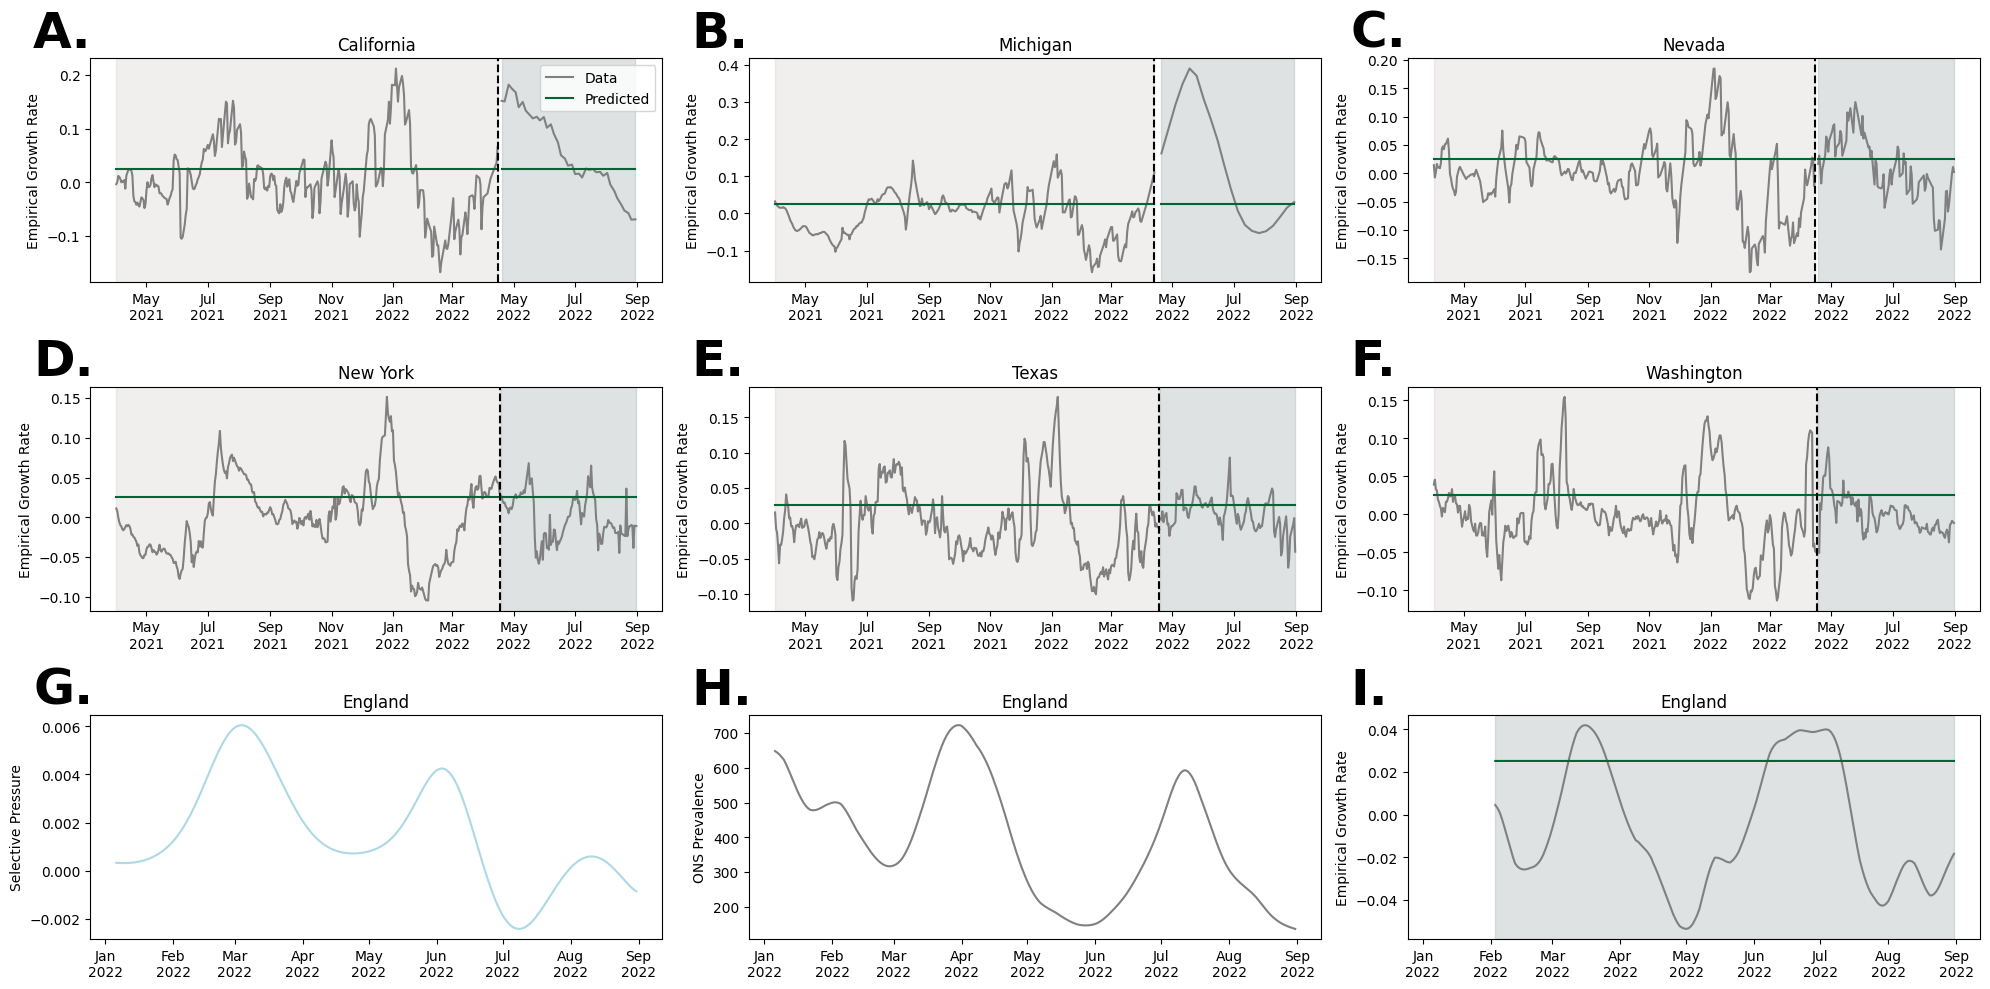

In [86]:
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=3, nrows=len(locations_subset) // 3 + 1)

TRAIN_PERIOD_COLOR, TEST_PERIOD_COLOR = "#d1c7c9", "#949fa5"
PREDICTION_COLOR = "#006633"
DATA_COLOR = "grey"

axes = []

data = {loc: df for loc, df in selective_pressure_df.groupby("location")}

for l, loc in enumerate(locations_subset):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X_train.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data point
    ax.plot(dates_vec[X_train.index][loc_idx_train], y_train[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    pred_train = model.apply(state.params, X_train[loc_idx_train].values)
    pred_test = model.apply(state.params, X_test[loc_idx_test].values)
    
    ax.plot(dates_vec[X_train.index][loc_idx_train], pred_train, color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], pred_test, color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X_train.index][loc_idx_train].min(), dates_vec[X_train.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()
    axes.append(ax)
    
# Add in target_locations
last_l = l
for l, loc in enumerate(target_locations):
    
    # Add selective pressure
    _l = 0
    ax = fig.add_subplot(spec[-1, 0], sharex=None if _l==0 else ax)
    ax.plot(data[loc]["date"], data[loc]["selective_pressure"], color="lightblue")
    ax.set_ylabel("Selective Pressure")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
    
    # Add prevalence
    ax = fig.add_subplot(spec[-1, 1], sharex = ax)    
    ax.plot(data[loc]["date"], data[loc]["smooth_cases"], color="grey")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("ONS Prevalence")
    axes.append(ax)
   
    # Add predictions
    ax = fig.add_subplot(spec[-1, -1], sharex=ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X_train.index]
    loc_idx_test = loc_idx[X_test.index]
    
    # Plot data points
    ax.plot(dates_vec[X_train.index][loc_idx_train], y_train[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    pred_train = model.apply(state.params, X_train[loc_idx_train].values)
    pred_test = model.apply(state.params, X_test[loc_idx_test].values)

    ax.plot(dates_vec[X_train.index][loc_idx_train], pred_train, color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], pred_test, color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X_train.index][loc_idx_train].min(), dates_vec[X_train.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)

ax_labels = string.ascii_uppercase 
for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
fig.tight_layout()